##  Parse and plot all data pointson 2-D plane

Data shape: (272, 2)
First few rows:
[[ 3.6   79.   ]
 [ 1.8   54.   ]
 [ 3.333 74.   ]
 [ 2.283 62.   ]
 [ 4.533 85.   ]]


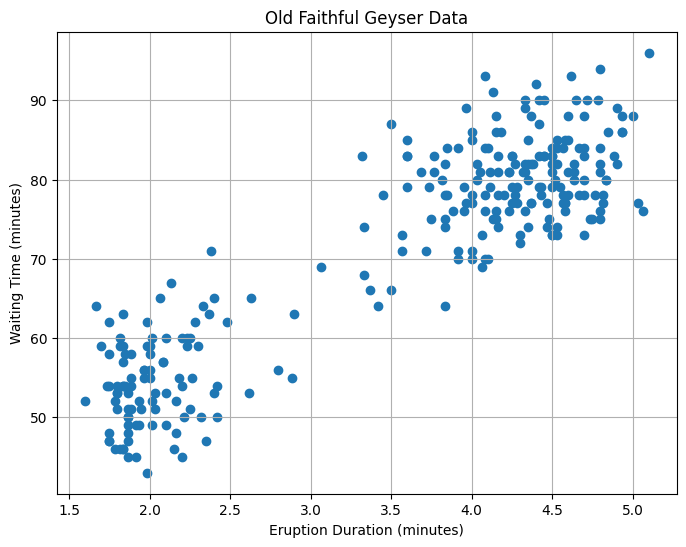

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load data from local file - skip the header (26 rows)
data = np.loadtxt('faithful.dat', skiprows=26, usecols=(1, 2))

print(f"Data shape: {data.shape}")
print(f"First few rows:\n{data[:5]}")

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1])
plt.xlabel('Eruption Duration (minutes)')
plt.ylabel('Waiting Time (minutes)')
plt.title('Old Faithful Geyser Data')
plt.grid(True)
plt.show()

## Implement and Run EM Algotrithm

### Implement the algorithm

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal

# Set random seed for reproducibility
np.random.seed(42)

# Number of clusters
K = 2
n_samples = data.shape[0]
n_features = data.shape[1]

# Means: pick 2 random data points as initial means
random_indices = np.random.choice(n_samples, K, replace=False)
mu = data[random_indices].copy()  # Shape: (2, 2)

# Covariances: use the data's covariance as a starting point
data_cov = np.cov(data.T)
sigma = [data_cov.copy() for _ in range(K)]  # List of 2x2 matrices

# Add small value to diagonal for numerical stability
for k in range(K):
    sigma[k] += np.eye(n_features) * 1e-6

# Mixing proportions
phi = np.ones(K) / K

print("Initial means:")
print(mu)
print("\nInitial covariances:")
print(sigma[0])
print("\nInitial mixing proportions:")
print(phi)

Initial means:
[[ 4.3   73.   ]
 [ 2.317 50.   ]]

Initial covariances:
[[  1.30272933  13.97780785]
 [ 13.97780785 184.82331335]]

Initial mixing proportions:
[0.5 0.5]


In [ ]:
def e_step(data, mu, sigma, phi):
    """
    E-step: Calculate posterior probabilities (responsibilities)

    Parameters:
    - data: (n_samples, n_features) array
    - mu: (K, n_features) array of means
    - sigma: list of K covariance matrices
    - phi: (K,) array of mixing proportions

    Returns:
    - responsibilities: (n_samples, K) array where entry [i,k] is P(z=k | x_i)
    """
    n_samples = data.shape[0]
    K = len(phi)

    # Initialize responsibilities matrix
    responsibilities = np.zeros((n_samples, K))

    # For each cluster k, calculate the Gaussian probability for all points
    for k in range(K):
        # Create multivariate normal distribution for cluster k
        mvn = multivariate_normal(mean=mu[k], cov=sigma[k])

        # Calculate probability density for all data points
        responsibilities[:, k] = phi[k] * mvn.pdf(data)

    # Normalize: divide by sum across clusters (denominator in formula)
    # Sum along axis=1 gives total probability for each point
    responsibilities_sum = responsibilities.sum(axis=1, keepdims=True)
    responsibilities = responsibilities / responsibilities_sum

    return responsibilities

In [18]:
# Test the E-step with initial parameters
responsibilities = e_step(data, mu, sigma, phi)
print("Responsibilities shape:", responsibilities.shape)  # Should be (272, 2)
print("First 5 responsibilities:")
print(responsibilities[:5])

Responsibilities shape: (272, 2)
First 5 responsibilities:
[[0.76031705 0.23968295]
 [0.1339214  0.8660786 ]
 [0.65529818 0.34470182]
 [0.27048215 0.72951785]
 [0.9150015  0.0849985 ]]


In [ ]:
def m_step(data, responsibilities):
    """
    M-step: Update parameters based on responsibilities

    Parameters:
    - data: (n_samples, n_features) array
    - responsibilities: (n_samples, K) array from E-step

    Returns:
    - mu: (K, n_features) updated means
    - sigma: list of K updated covariance matrices
    - phi: (K,) updated mixing proportions
    """
    n_samples, n_features = data.shape
    K = responsibilities.shape[1]

    # Initialize new parameters
    mu = np.zeros((K, n_features))
    sigma = []
    phi = np.zeros(K)

    for k in range(K):
        # Get responsibilities for cluster k
        resp_k = responsibilities[:, k]  # Shape: (n_samples,)

        # Effective number of points in cluster k
        N_k = resp_k.sum()

        # Update phi_k: average responsibility
        phi[k] = N_k / n_samples

        # Update mu_k: weighted average of data points
        mu[k] = (resp_k[:, np.newaxis] * data).sum(axis=0) / N_k

        # Update sigma_k: weighted covariance
        diff = data - mu[k]  # (n_samples, n_features)
        weighted_diff = resp_k[:, np.newaxis] * diff  # Weight by responsibilities
        sigma_k = (weighted_diff.T @ diff) / N_k

        # Add small value to diagonal for numerical stability
        sigma_k += np.eye(n_features) * 1e-6
        sigma.append(sigma_k)

    return mu, sigma, phi

# Test the M-step
mu_new, sigma_new, phi_new = m_step(data, responsibilities)

print("Updated means:")
print(mu_new)
print("\nUpdated mixing proportions:")
print(phi_new)
print("Sum of phi:", phi_new.sum())  # Should be 1.0

Updated means:
[[ 4.09795246 77.91983165]
 [ 2.52316549 59.79474765]]

Updated mixing proportions:
[0.61253847 0.38746153]
Sum of phi: 1.0


In [ ]:
def em_algorithm(data, K=2, max_iterations=100, tolerance=1e-4):
    """
    Complete EM algorithm

    Parameters:
    - data: (n_samples, n_features) array
    - K: number of clusters
    - max_iterations: maximum number of iterations
    - tolerance: convergence threshold

    Returns:
    - mu: final means
    - sigma: final covariances
    - phi: final mixing proportions
    - mu_history: list of means at each iteration (for plotting trajectories)
    """
    n_samples, n_features = data.shape

    # Initialize parameters
    np.random.seed(42)
    random_indices = np.random.choice(n_samples, K, replace=False)
    mu = data[random_indices].copy()

    data_cov = np.cov(data.T)
    sigma = [data_cov.copy() for _ in range(K)]
    for k in range(K):
        sigma[k] += np.eye(n_features) * 1e-6

    phi = np.ones(K) / K

    # Store history of means for plotting trajectories
    mu_history = [mu.copy()]

    # EM loop
    for iteration in range(max_iterations):
        # E-step
        responsibilities = e_step(data, mu, sigma, phi)

        # M-step
        mu_new, sigma_new, phi_new = m_step(data, responsibilities)

        # Check convergence: compare change in means
        mu_change = np.linalg.norm(mu_new - mu)

        # Update parameters
        mu = mu_new
        sigma = sigma_new
        phi = phi_new

        # Store mu for trajectory plotting
        mu_history.append(mu.copy())

        # Print progress
        if (iteration + 1) % 10 == 0:
            print(f"Iteration {iteration + 1}: mu_change = {mu_change:.6f}")

        # Check convergence
        if mu_change < tolerance:
            print(f"Converged after {iteration + 1} iterations!")
            break

    return mu, sigma, phi, mu_history

# Run EM algorithm
mu_final, sigma_final, phi_final, mu_history = em_algorithm(data, K=2)

print("\n=== Final Results ===")
print("Final means:")
print(mu_final)
print("\nFinal mixing proportions:")
print(phi_final)

Iteration 10: mu_change = 0.000534
Converged after 12 iterations!

=== Final Results ===
Final means:
[[ 4.28966265 79.96812337]
 [ 2.03638922 54.47852405]]

Final mixing proportions:
[0.64412683 0.35587317]


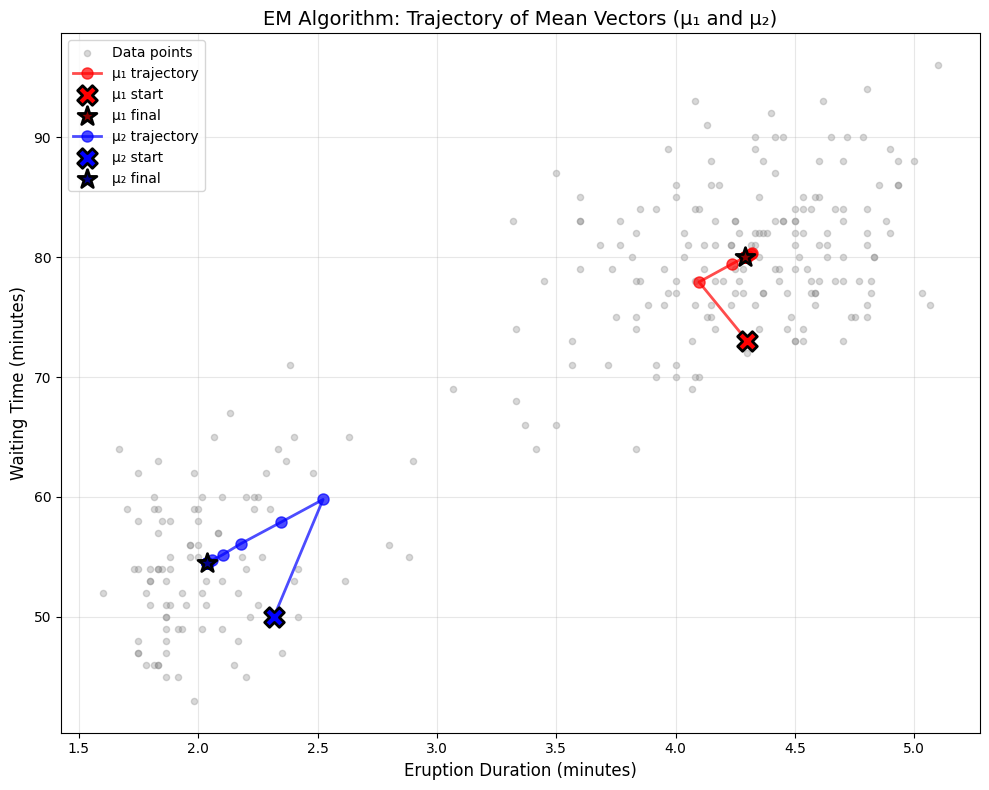

Total iterations: 12

μ₁ moved from [ 4.3 73. ] to [ 4.28966265 79.96812337]
μ₂ moved from [ 2.317 50.   ] to [ 2.03638922 54.47852405]


In [ ]:
# Plot trajectories of the two means
plt.figure(figsize=(10, 8))

# Plot the data points
plt.scatter(data[:, 0], data[:, 1], alpha=0.3, s=20, c='gray', label='Data points')

# Extract trajectories for each cluster
mu_history_array = np.array(mu_history)  # Shape: (n_iterations+1, K, n_features)

# Plot trajectory for cluster 1 (mu_1)
mu1_trajectory = mu_history_array[:, 0, :]  # All iterations, cluster 0
plt.plot(mu1_trajectory[:, 0], mu1_trajectory[:, 1],
         'o-', linewidth=2, markersize=8, color='red',
         label='μ₁ trajectory', alpha=0.7)

# Mark start and end for cluster 1
plt.scatter(mu1_trajectory[0, 0], mu1_trajectory[0, 1],
           s=200, c='red', marker='X', edgecolors='black',
           linewidths=2, label='μ₁ start', zorder=5)
plt.scatter(mu1_trajectory[-1, 0], mu1_trajectory[-1, 1],
           s=200, c='darkred', marker='*', edgecolors='black',
           linewidths=2, label='μ₁ final', zorder=5)

# Plot trajectory for cluster 2 (mu_2)
mu2_trajectory = mu_history_array[:, 1, :]  # All iterations, cluster 1
plt.plot(mu2_trajectory[:, 0], mu2_trajectory[:, 1],
         'o-', linewidth=2, markersize=8, color='blue',
         label='μ₂ trajectory', alpha=0.7)

# Mark start and end for cluster 2
plt.scatter(mu2_trajectory[0, 0], mu2_trajectory[0, 1],
           s=200, c='blue', marker='X', edgecolors='black',
           linewidths=2, label='μ₂ start', zorder=5)
plt.scatter(mu2_trajectory[-1, 0], mu2_trajectory[-1, 1],
           s=200, c='darkblue', marker='*', edgecolors='black',
           linewidths=2, label='μ₂ final', zorder=5)

plt.xlabel('Eruption Duration (minutes)', fontsize=12)
plt.ylabel('Waiting Time (minutes)', fontsize=12)
plt.title('EM Algorithm: Trajectory of Mean Vectors (μ₁ and μ₂)', fontsize=14)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total iterations: {len(mu_history) - 1}")
print(f"\nμ₁ moved from {mu1_trajectory[0]} to {mu1_trajectory[-1]}")
print(f"μ₂ moved from {mu2_trajectory[0]} to {mu2_trajectory[-1]}")